In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

import models as M
from train import load_data
import yaml
from tqdm import tqdm

def gen_uncertainty_df(y_pred, y_models_pred=None):
    entropy = []

    # y_pred is either dnn predictions or mean predictions from bnn
    for i in range(len(y_pred)):
        entropy_i = calc_entropy(y_pred[i])
        entropy.append(entropy_i)
    entropy_np = np.array(entropy)
    
    if y_models_pred is None:
        # if dnn, we only get aleatoric uncertainty
        uncertainty_df = pd.DataFrame(entropy_np, columns=['Aleatoric Uncertainty'])
    else:
        total_uncertainty = entropy_np
        
        # Aleatoric uncertainty: expected value of entropy under models
        # calc aleatoric uncertainty = mean of entropy of predections for each model
        entropies = []
        for n in tqdm(range(20)):
            n_ale = []
            for i in range(len(y_models_pred[n])):
                # calc entropy for model with weights W
                entropy_n = calc_entropy(y_models_pred[n,i])
                # entropy value per prediction
                n_ale.append(entropy_n)
            # set of len(dataset) entropy values per model
            entropies.append(n_ale)
        entropies_np = np.array(entropies)
        print('shape of array:', entropies_np.shape)
        aleatoric_uncertainty = np.mean(entropies_np, axis=0)
        '''
        total_variation = np.sum(np.var(y_models_pred, axis=0), axis=1)
        '''
        
        epistemic_uncertainty = total_uncertainty - aleatoric_uncertainty

        out_np = np.vstack((epistemic_uncertainty, aleatoric_uncertainty, total_uncertainty))
        out_np = np.swapaxes(out_np, 0, 1)
        
        uncertainty_df = pd.DataFrame(out_np, columns=['Epistemic Uncertainty', 'Aleatoric Uncertainty', 'Total Uncertainty'])
    
    return uncertainty_df

def calc_entropy(y):
    return -((y[0]*np.log(y[0]))+(y[1]*np.log(y[1]+1e-15))) # add 1e-15 for numerical stability - no NaNs please

2023-11-01 20:45:11.354472: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-01 20:45:11.418383: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-01 20:45:12.682015: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Using TensorFlow backend
tf INFO messages are suppressed.
sklearn version: 1.3.1


## DNN Model

In [14]:
dnn_weights_path = '/smallwork/alexander.huang/models/2023-10-13/49111756_outbound_dnn_run_2023-10-13 13:27:28.481509/checkpoint100-0.06.h5'
dnn_params_path = '/smallwork/alexander.huang/models/2023-10-13/49111756_outbound_dnn_run_2023-10-13 13:27:28.481509/params.yml'

with open(dnn_params_path, 'r') as file:
    params = yaml.load(file, Loader=yaml.loader.FullLoader)

# load model architecture and model weights
model = M.get_dnn_model(params)
model.load_weights(dnn_weights_path)
model.summary()

Model: "dnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 250)]             0         
                                                                 
 hidden_1 (Dense)            (None, 512)               128512    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 hidden_2 (Dense)            (None, 512)               262656    
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 output (Dense)              (None, 2)                 1026      
                                                                 
Total params: 392194 (1.50 MB)
Trainable params: 392194 (1.50 M

In [8]:
_, _, _, _, x_test, y_test = load_data('outbound')


======== loadiing train and test data ==========
load x_train
load y_train
load x_test
load x_test
load x_val
load y_val
...load complete.
imported training data:
x_train shape: (12220423, 250)
y_train shape: (12220423,)
[(0.0, 11968256), (1.0, 252167)]
imported validation data:
x_val shape: (1359117, 250)
y_val shape: (1359117,)
[(0.0, 1330996), (1.0, 28121)]
imported test data:
x_test shape: (3585962, 250)
y_test shape: (3585962,)
[(0.0, 3496914), (1.0, 89048)]


In [16]:
y_pred_dnn = model.predict(x_test)

112062/112062 [==============================] - 120s 1ms/step


In [17]:
y_pred_classes = np.where(y_pred_dnn[:,1] > 0.54810953, 1, 0)
print(y_pred_classes.shape)

(3585962,)


In [18]:
print(classification_report(y_test, y_pred_classes, digits=4))

              precision    recall  f1-score   support

         0.0     0.9974    0.9956    0.9965   3496914
         1.0     0.8402    0.8984    0.8684     89048

    accuracy                         0.9932   3585962
   macro avg     0.9188    0.9470    0.9324   3585962
weighted avg     0.9935    0.9932    0.9933   3585962



In [19]:
dnn_uncertainty_df = gen_uncertainty_df(y_pred_dnn)

(3585962,)
[0.03758415 0.03849279 0.08855512 ... 0.03592022 0.99155167 0.99849075]


In [21]:
dnn_uncertainty_df

,Aleatoric Uncertainty
0,0.037584
1,0.038493
2,0.088555
3,0.065834
4,0.010979
...,...
3585957,0.066860
3585958,0.069723
3585959,0.035920
3585960,0.991552


In [22]:
dnn_uncertainty_df.to_parquet('dnn_uncertainty.parq')

## MC Dropout

In [2]:
mcd_pred = np.load('/smallwork/alexander.huang/mcdropout/outbound/49114307/predictions.npy')
print(mcd_pred.shape)

(20, 3585962, 2)


In [3]:
y_pred_mcd = np.mean(mcd_pred, axis=0)
print(y_pred_mcd.shape)

(3585962, 2)


In [13]:
mcd_uncertainty_df = gen_uncertainty_df(y_pred_mcd, mcd_pred)
mcd_uncertainty_df

100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [04:48<00:00, 14.43s/it]


,Epistemic Uncertainty,Aleatoric Uncertainty,Total Uncertainty
0,0.000549,0.027628,0.028178
1,0.000255,0.026869,0.027124
2,0.000450,0.066124,0.066574
3,0.000801,0.047193,0.047994
4,0.000079,0.006697,0.006777
...,...,...,...
3585957,0.000634,0.051451,0.052085
3585958,0.001063,0.046537,0.047600
3585959,0.000553,0.030353,0.030906
3585960,0.004158,0.685159,0.689317


In [24]:
mcd_uncertainty_df.iloc[204]

Epistemic Uncertainty    0.005389
Aleatoric Uncertainty    0.684437
Total Uncertainty        0.689826
Name: 204, dtype: float64

In [23]:
mcd_uncertainty_df.to_parquet('mcd_uncertainty.parq')

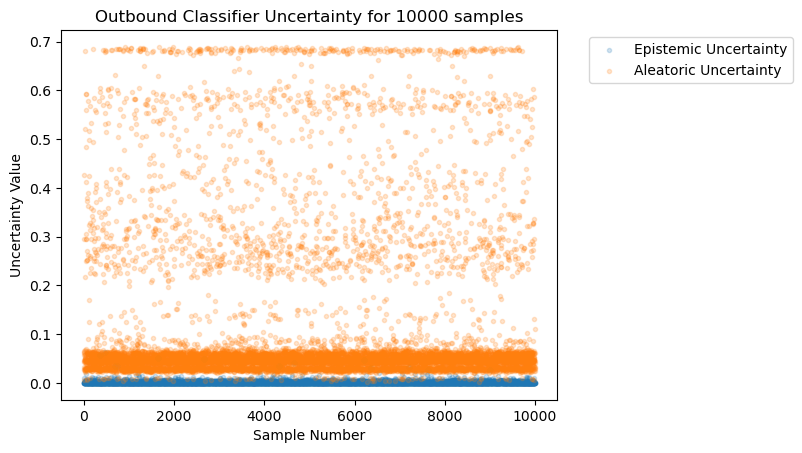

In [22]:
fig, ax=plt.subplots()
ax.scatter(mcd_uncertainty_df.index[:10000], mcd_uncertainty_df['Epistemic Uncertainty'][:10000], alpha=0.2, marker='.', label='Epistemic Uncertainty')
ax.scatter(mcd_uncertainty_df.index[:10000], mcd_uncertainty_df['Aleatoric Uncertainty'][:10000], alpha=0.2, marker='.', label='Aleatoric Uncertainty')
ax.legend(loc='upper left', bbox_to_anchor=(1.05,1.0))
plt.xlabel('Sample Number')
plt.ylabel('Uncertainty Value')
plt.title('Outbound Classifier Uncertainty for 10000 samples')
plt.show()

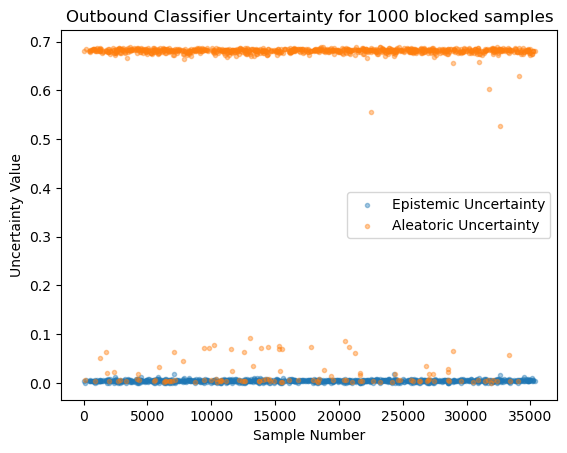

In [17]:
mcd_thresh = 0.5276166
block_index = np.where(y_pred_mcd[:,1] > mcd_thresh)[0]
b_idx=block_index.tolist()
len(b_idx)
test = b_idx[:1000]

fig, ax=plt.subplots()

ax.scatter(mcd_uncertainty_df.index[test], mcd_uncertainty_df['Epistemic Uncertainty'][test], alpha=0.4, marker='.', label='Epistemic Uncertainty')
ax.scatter(mcd_uncertainty_df.index[test], mcd_uncertainty_df['Aleatoric Uncertainty'][test], alpha=0.4, marker='.', label='Aleatoric Uncertainty')
ax.legend()
plt.xlabel('Sample Number')
plt.ylabel('Uncertainty Value')
plt.title('Outbound Classifier Uncertainty for 1000 blocked samples')
plt.show()

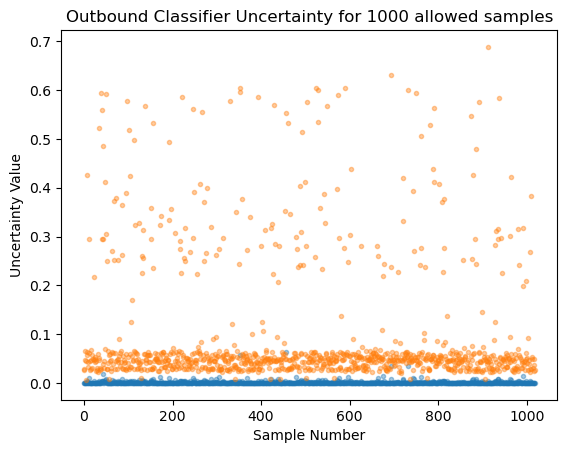

In [18]:
mcd_thresh = 0.5276166
allow_index = np.where(y_pred_mcd[:,1] < mcd_thresh)[0]
a_idx=allow_index.tolist()
len(a_idx)
test = a_idx[:1000]

fig, ax=plt.subplots()

ax.scatter(mcd_uncertainty_df.index[test], mcd_uncertainty_df['Epistemic Uncertainty'][test], alpha=0.4, marker='.', label='Epistemic Uncertainty')
ax.scatter(mcd_uncertainty_df.index[test], mcd_uncertainty_df['Aleatoric Uncertainty'][test], alpha=0.4, marker='.', label='Aleatoric Uncertainty')
#ax.legend()
plt.xlabel('Sample Number')
plt.ylabel('Uncertainty Value')
plt.title('Outbound Classifier Uncertainty for 1000 allowed samples')
plt.show()

## Concrete Dropout

In [4]:
cd_pred = np.load('/smallwork/alexander.huang/concrete_dropout/outbound/49114892/predictions.npy')
print(cd_pred.shape)

(20, 3585962, 2)


In [5]:
y_pred_cd = np.mean(cd_pred, axis=0)
print(y_pred_cd.shape)

(3585962, 2)


In [4]:
cd_uncertainty_df = gen_uncertainty_df(y_pred_cd, cd_pred)
cd_uncertainty_df

100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [05:25<00:00, 16.28s/it]


shape of array: (20, 3585962)


,Epistemic Uncertainty,Aleatoric Uncertainty,Total Uncertainty
0,0.000083,0.028187,0.028270
1,0.000079,0.025622,0.025702
2,0.000103,0.058110,0.058214
3,0.000136,0.042048,0.042184
4,0.000042,0.005226,0.005268
...,...,...,...
3585957,0.000231,0.046231,0.046463
3585958,0.000457,0.050353,0.050811
3585959,0.000198,0.026906,0.027104
3585960,0.001317,0.688670,0.689988


In [5]:
cd_uncertainty_df.to_parquet('cd_uncertainty_.parq')

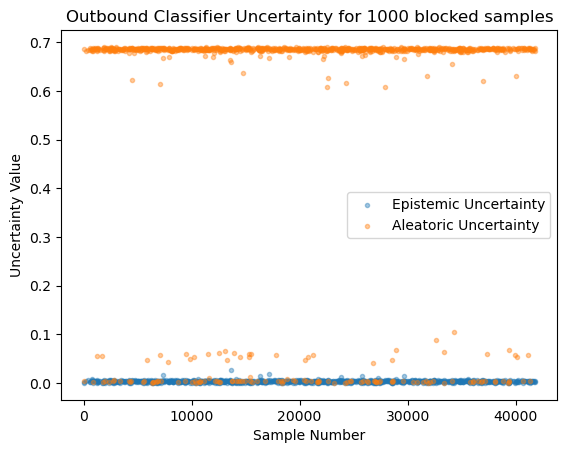

In [6]:
cd_thresh = 0.5276166
block_index = np.where(y_pred_cd[:,1] > cd_thresh)[0]
b_idx=block_index.tolist()
len(b_idx)
test = b_idx[:1000]

fig, ax=plt.subplots()

ax.scatter(cd_uncertainty_df.index[test], cd_uncertainty_df['Epistemic Uncertainty'][test], alpha=0.4, marker='.', label='Epistemic Uncertainty')
ax.scatter(cd_uncertainty_df.index[test], cd_uncertainty_df['Aleatoric Uncertainty'][test], alpha=0.4, marker='.', label='Aleatoric Uncertainty')
ax.legend()
plt.xlabel('Sample Number')
plt.ylabel('Uncertainty Value')
plt.title('Outbound Classifier Uncertainty for 1000 blocked samples')
plt.show()

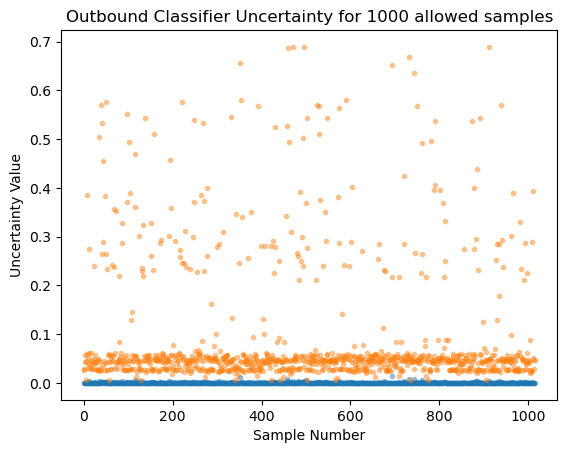

In [7]:
cd_thresh = 0.5276166
allow_index = np.where(y_pred_cd[:,1] < cd_thresh)[0]
a_idx=allow_index.tolist()
len(a_idx)
test = a_idx[:1000]

fig, ax=plt.subplots()

ax.scatter(cd_uncertainty_df.index[test], cd_uncertainty_df['Epistemic Uncertainty'][test], alpha=0.4, marker='.', label='Epistemic Uncertainty')
ax.scatter(cd_uncertainty_df.index[test], cd_uncertainty_df['Aleatoric Uncertainty'][test], alpha=0.4, marker='.', label='Aleatoric Uncertainty')
#ax.legend()
plt.xlabel('Sample Number')
plt.ylabel('Uncertainty Value')
plt.title('Outbound Classifier Uncertainty for 1000 allowed samples')
plt.show()

# Concrete Dropout Calibration

In [2]:
from torchmetrics.classification import BinaryCalibrationError
from sklearn.calibration import CalibrationDisplay
import torch

In [3]:
cd_pred = np.load('/smallwork/alexander.huang/concrete_dropout/outbound/49114892/predictions.npy')

In [4]:
cd_pred.shape

(20, 3585962, 2)

In [5]:
cd_pred_mean = np.mean(cd_pred, axis=0)
cd_pred_pos = cd_pred_mean[:,1]
print(cd_pred_pos.shape)
print(cd_pred_pos)

(3585962,)
[0.00440084 0.00393191 0.01048391 ... 0.00418687 0.5397256  0.49611035]


In [6]:
metric = BinaryCalibrationError(n_bins=30, norm='l1')

In [7]:
cd_pred_pos_tensor = torch.from_numpy(cd_pred_pos)
y_test_tensor = torch.from_numpy(y_test)
metric(cd_pred_pos_tensor, y_test_tensor)

NameError: name 'y_test' is not defined

# MCD Calibration

In [137]:
mcd_pred = np.load('/smallwork/alexander.huang/mcdropout/outbound/49114307/predictions.npy')

In [138]:
mcd_pred.shape

(20, 3585962, 2)

In [139]:
mcd_pred_mean = np.mean(mcd_pred, axis=0)
mcd_pred_pos = mcd_pred_mean[:,1]
print(mcd_pred_pos.shape)
print(mcd_pred_pos)

(3585962,)
[0.00438379 0.00419037 0.01235771 ... 0.00489205 0.543734   0.5131346 ]


In [140]:
mcd_metric = BinaryCalibrationError(n_bins=30, norm='l1')

In [141]:
mcd_pred_pos_tensor = torch.from_numpy(cd_pred_pos)
metric(mcd_pred_pos_tensor, y_test_tensor)

tensor(0.0333)

Text(0.5, 1.0, 'Calibration')

<Figure size 5000x5000 with 0 Axes>

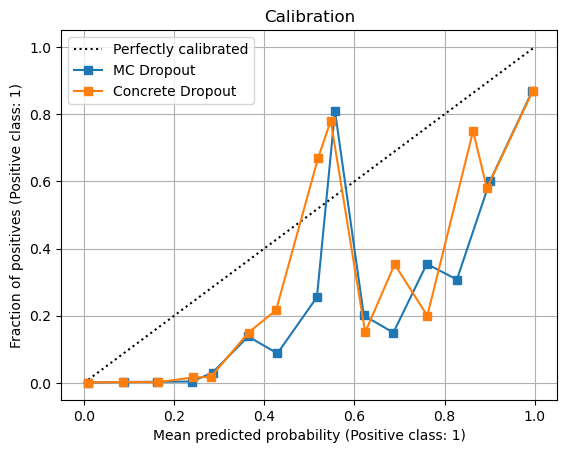

In [142]:
fig = plt.figure(figsize=(50,50))
fig, ax = plt.subplots()
display = CalibrationDisplay.from_predictions(y_test, mcd_pred_pos, n_bins=15, name='MC Dropout', ax=ax, pos_label=1)
display = CalibrationDisplay.from_predictions(y_test, cd_pred_pos, n_bins=15, name='Concrete Dropout', ax=ax, pos_label=1)
ax.legend(loc='upper left')
plt.grid()
plt.title('Calibration')
